In [1]:
import ray
from ray import tune
import gym
import abides_gym
from ray.tune.registry import register_env
from abides_gym.envs.markets_daily_investor_environment_v0 import SubGymMarketsDailyInvestorEnv_v0
from ray.rllib.agents.callbacks import DefaultCallbacks
import numpy as np 
#np.random.seed(0)
from ray.tune import Analysis
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
# sys.path.append('/mnt/ccnas2/bdp/kg1118/projects/jpm/my_abides/')
from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.orders import Side
from abides_markets.configs.flash_crash import build_config
from abides_markets.configs.agent_params import ExchangeConfig, NoiseAgentConfig, ValueAgentConfig, MarketMakerAgentConfig, MomentumAgentConfig, GBMOracleConfig, InstitutionalTraderAgentConfig
from abides_markets.oracles.mean_reverting_oracle import MeanRevertingOracle
import os
print(os.getcwd())

/vol/bitbucket/ik620/agent_based_learning_for_finance/notebooks


In [3]:
class MyCustomCallbacks(DefaultCallbacks):
    def on_train_result(self, *, trainer, result: dict, **kwargs):
        print(f"Iteration: {result['training_iteration']}, "
              f"Episode Reward Mean: {result['episode_reward_mean']:.2f}, "
              f"Total Timesteps: {result['timesteps_total']}")
        
        # if result['timesteps_total'] % 100 == 0:
        #     print(f"Total Timesteps: {result['timesteps_total']}, "
        #           f"Episode Reward Mean: {result['episode_reward_mean']:.2f}, "
        #           f"Iteration: {result['training_iteration']}")
        

In [4]:
register_env(
        "markets-daily_investor-v0",
        lambda config: SubGymMarketsDailyInvestorEnv_v0(**config),
    )

In [5]:
def train_ray_model(agent_type, iterations, verbose, config_extra, env_config):

    ray.shutdown()
    ray.init()

    local_dir = "./"
    name_xp = "ray_trading"+agent_type #change to your convenience

    basics = {"env": "markets-daily_investor-v0", "env_config": env_config, "callbacks": MyCustomCallbacks}
    config_extra.update(basics)

    tune.run(
        agent_type,
        name=name_xp,
        local_dir=local_dir,
        stop={"training_iteration": iterations},  
        checkpoint_at_end=True,
        checkpoint_freq=1,
        verbose=verbose,
        config=config_extra,
    )

    return

In [2]:
import ray.rllib.agents.dqn as dqn
import ray.rllib.agents.sac as sac
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.pg as pg
import ray.rllib.agents.ddpg as ddpg

class policyRL:
    """
    policy learned during the training
    get the best policy from training {name_xp}
    Use this policy to compute action
    """
    def __init__(self, agent_type, config_extra):
        self.name = 'rl'
        ##### LOADING POLICY 
        # cell specific to ray to 
        #this part is to get a path
        # https://github.com/ray-project/ray/issues/4569#issuecomment-480453957
        name_xp = "ray_trading"+agent_type
        data_folder = f"./{name_xp}"

        if agent_type == 'DQN':
            config = dqn.DEFAULT_CONFIG.copy()
            config.update(config_extra)
            self.trainer = dqn.DQNTrainer(config=config, env="markets-daily_investor-v0")
        elif agent_type == 'SAC':
            config = sac.DEFAULT_CONFIG.copy()
            config.update(config_extra)
            self.trainer = sac.SACTrainer(config=config, env="markets-daily_investor-v0")
        elif agent_type == 'PPO':
            config = ppo.DEFAULT_CONFIG.copy()
            config.update(config_extra)
            self.trainer = ppo.PPOTrainer(config=config, env="markets-daily_investor-v0")
        elif agent_type == 'PG':
            config = pg.DEFAULT_CONFIG.copy()
            config.update(config_extra)
            self.trainer = pg.PGTrainer(config=config, env="markets-daily_investor-v0")
        elif agent_type == 'DDPG':
            config = ddpg.DEFAULT_CONFIG.copy()
            config.update(config_extra)
            self.trainer = ddpg.DDPGTrainer(config=config, env="markets-daily_investor-v0")
        else:
            raise ValueError(f"Unsupported agent type: {agent_type}")
        
        analysis = Analysis(data_folder)
        trial_dataframes = analysis.trial_dataframes
        trials = list(trial_dataframes.keys())
        print(trials)
        best_trial_path = analysis.get_best_logdir(metric='episode_reward_mean', mode='max')
        print('best trial path', best_trial_path)
        #can replace by string here - any checkpoint of your choice 
        best_checkpoint = analysis.get_best_checkpoint(trial = best_trial_path, mode='max')
        print('best checkpoint', best_checkpoint)
        
        #load policy from checkpoint
        self.trainer.restore(best_checkpoint)
        
        
    def get_action(self, state):
        return self.trainer.compute_action(state)    
        

In [3]:
def test_ray_model(policy, seed, env):

    env.seed(seed)
    state = env.reset()
    done = False
    total_reward = 0

    test_data = {'last_transaction': [], 'best_bid': [], 'best_ask': [], 'action': [], 'reward': [], 
                 'total_reward': [], 'total_volume': [], 'spread': [], 'volume': [], 'marked_to_market': []}

    cnt = 0
    while not done:
        action = policy.get_action(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
        cnt += 1
        if not cnt % 100:
            print('iteration:', cnt)

        # for key, value in info.items():
        #     print(key, value)
        # print(info['bids'])
        # print(info['asks'])

        test_data['last_transaction'].append(info['last_transaction'])
        test_data['best_bid'].append(info['best_bid'])
        test_data['best_ask'].append(info['best_ask'])
        test_data['action'].append(action)
        test_data['reward'].append(reward)
        test_data['total_reward'].append(total_reward)
        test_data['spread'].append(info['spread'])
        test_data['marked_to_market'].append(info['marked_to_market'])
        #test_data['total_volume'].append(info['total_volume'])

    return test_data

In [4]:
def plot_market_discrete(test_data):

    colors = {0: 'r', 2: 'b'}  # 0 for Buy (red), 2 for Sell (blue)
    color_map = [colors.get(int(action), None) for action in test_data['action']]
    
    buy_patch = mpatches.Patch(color='r', label='Buy')
    sell_patch = mpatches.Patch(color='b', label='Sell')

    plt.legend(handles=[buy_patch, sell_patch])
    plt.plot(range(len(test_data['last_transaction'])), test_data['last_transaction'], label='Last Transaction Price')

    # Scatter only for actions 0 (Buy) and 2 (Sell)
    for idx, (action, price) in enumerate(zip(test_data['action'], test_data['last_transaction'])):
        if action in colors:
            plt.scatter(idx, price, color=colors[action])

    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.title('Best Transaction Prices with Action-Based Colors')
    plt.show()



In [5]:
def plot_total_reward(test_data):

    plt.plot(test_data['total_reward'])
    plt.title('Total Reward')
    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [6]:
def plot_reward(test_data):

    plt.plot(test_data['reward'])
    plt.title('Reward')
    plt.xlabel('Time')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel('Reward')
    plt.show()

In [7]:
def plot_marked_to_market(test_data):

    plt.plot(test_data['marked_to_market'])
    plt.title('Marked to Market')
    plt.xlabel('Time')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel('Value')
    plt.show()

In [8]:
oracle_config = GBMOracleConfig(mu=1e-9, sigma=0.0135)
mm_config = MarketMakerAgentConfig(price_skew_param=4, wake_up_freq='1s', subscribe=False, subscribe_freq='1s', subscribe_num_levels=10)
# mm_config = MarketMakerAgentConfig(price_skew_param=4, wake_up_freq=1e9 * (5) , subscribe=False, subscribe_freq='1s', subscribe_num_levels=10)
value_agent_config = ValueAgentConfig(kappa_limit=0.3, kappa_mkt=0.1, mean_wakeup_gap=1e8)
# value_agent_config = ValueAgentConfig(kappa_limit=0.3, kappa_mkt=0.1, mean_wakeup_gap=1e8 * (5))
momentum_agent_config = MomentumAgentConfig(beta_limit=50, beta_mkt=20, wake_up_freq='1s', subscribe=False)
# momentum_agent_config = MomentumAgentConfig(beta_limit=50, beta_mkt=20, wake_up_freq=1e9 * (5), subscribe=False)

exchange_config = ExchangeConfig(log_orders=True)
institutional_config = InstitutionalTraderAgentConfig(inventory=1e13, sell_frequency="00:00:02", sell_volume_factor=1000)

changes_fc = {
    "num_noise_agents": 15,
    "num_value_agents": 10,
    "num_mm_agents": 19,
    "num_long_momentum_agents": 5,
    "num_short_momentum_agents": 5,
    "oracle_params": oracle_config,
    "mm_agent_params": mm_config,
    "value_agent_params": value_agent_config,
    "momentum_agent_params": momentum_agent_config
}

config_extra = {"framework": "torch",
                "timesteps_per_iteration": 1000,
                "observation_filter": "MeanStdFilter",
                "num_workers": 7,
                }
env_config = {"background_config": "flash_crash", "background_config_extra_kvargs": changes_fc, 
              "timestep_duration": "1s", "mkt_close": "09:35:00", "first_interval": "00:00:01",
              "done_ratio": float("-inf"), "order_fixed_size": int((1e10)/2), "state_history_length": 8, "reward_lookback": 8}
# env_config = {"done_ratio": float("-inf"), "order_fixed_size": int((1e17)),
#               "state_history_length": 8, "reward_lookback": 8}

agent_type = 'SAC'

env = gym.make("markets-daily_investor-v0", debug_mode=True, **env_config)

NameError: name 'GBMOracleConfig' is not defined

In [ ]:
train_ray_model(agent_type=agent_type, iterations=10, verbose=0, config_extra=config_extra, env_config=env_config)

(pid=2177236) 2024-07-04 20:57:32,362	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=2177218) USING BACKGROUND CONFIG flash_crash
(RolloutWorker pid=2177218) {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x7c4a24963d30>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig object at 0x7c4a24963af0>, 'value_agent_params': <abides_markets.configs.agent_params.ValueAgentConfig object at 0x7c4a24963ac0>, 'momentum_agent_params': <abides_markets.configs.agent_params.MomentumAgentConfig object at 0x7c4a24963a60>}
(RolloutWorker pid=2177218) {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x7c4a24963d30>, 'mm_agent_params': <abides_markets.configs.age

(pid=2177218) 2024-07-04 20:57:37,911	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(pid=2177236) 2024-07-04 20:57:38,052	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(pid=2177236) 2024-07-04 20:57:38,058	WARNING deprecation.py:38 -- DeprecationWarning: `ReplayBuffer(size)` has been deprecated. Use `ReplayBuffer(capacity)` instead. This will raise an error in the future!
(pid=2177236) 2024-07-04 20:57:38,061	WARNING util.py:57 -- Install gputil for GPU system monitoring.


(RolloutWorker pid=2177218) {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x7c4a24963d30>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig object at 0x7c4a24963af0>, 'value_agent_params': <abides_markets.configs.agent_params.ValueAgentConfig object at 0x7c4a24963ac0>, 'momentum_agent_params': <abides_markets.configs.agent_params.MomentumAgentConfig object at 0x7c4a24963a60>, 'seed': 1931006773}
(RolloutWorker pid=2177218) background config is flash_crash
(RolloutWorker pid=2177218) YUPPPPP
(RolloutWorker pid=2177218) (<function build_config at 0x7c4a249721f0>, {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent

(pid=2177230) [2024-07-04 21:32:57,702 E 2177230 2178732] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
(pid=2177237) [2024-07-04 21:32:57,703 E 2177237 2178726] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
(pid=2177228) [2024-07-04 21:32:57,703 E 2177228 2178708] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.
(pid=2177223) [2024-07-04 21:32:57,703 E 2177223 2178702] raylet_client.cc:159: IOError: Broken pipe [RayletClient] Failed to disconnect from raylet.


In [ ]:
policy = policyRL(agent_type=agent_type,config_extra=config_extra)

2024-07-04 21:32:57,876	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=2177220) USING BACKGROUND CONFIG flash_crash
(RolloutWorker pid=2177220) {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x78752a162dc0>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig object at 0x78752a162bb0>, 'value_agent_params': <abides_markets.configs.agent_params.ValueAgentConfig object at 0x78752a162b20>, 'momentum_agent_params': <abides_markets.configs.agent_params.MomentumAgentConfig object at 0x78752a1629d0>}
(RolloutWorker pid=2177220) {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x78752a162dc0>, 'mm_agent_params': <abides_markets.configs.age

(pid=2177215) 2024-07-04 21:33:06,428	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


2024-07-04 21:33:06,545	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2024-07-04 21:33:06,554	WARNING deprecation.py:38 -- DeprecationWarning: `ReplayBuffer(size)` has been deprecated. Use `ReplayBuffer(capacity)` instead. This will raise an error in the future!
2024-07-04 21:33:06,558	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2024-07-04 21:33:06,822	INFO trainable.py:416 -- Restored on 146.169.1.59 from checkpoint: ./ray_tradingSAC/SAC_markets-daily_investor-v0_a301a_00000_0_2024-07-04_20-57-26/checkpoint_000010/checkpoint-10
2024-07-04 21:33:06,823	INFO trainable.py:424 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 0, '_time_total': 2117.671264410019, '_episodes_total': 28}


['./ray_tradingSAC/SAC_markets-daily_investor-v0_a301a_00000_0_2024-07-04_20-57-26']
best trial path ./ray_tradingSAC/SAC_markets-daily_investor-v0_a301a_00000_0_2024-07-04_20-57-26
best checkpoint ./ray_tradingSAC/SAC_markets-daily_investor-v0_a301a_00000_0_2024-07-04_20-57-26/checkpoint_000010/checkpoint-10


In [ ]:
class policyPassive:
    def __init__(self):
        self.name = 'passive'
        self.cnt = 0
        
    def get_action(self, state):
        return 1

class policyAggressive:
    def __init__(self):
        self.name = 'aggressive'
        self.cnt = 0
        
    def get_action(self, state):
        self.cnt += 1

        if self.cnt > 60 and self.cnt < 160:
            return 0
        else:
            return 1
    
#policy = policyPassive()

test_data = test_ray_model(policy, seed=65, env=env)

{'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x77ff7bdc7b50>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig object at 0x77ff7bdc7cd0>, 'value_agent_params': <abides_markets.configs.agent_params.ValueAgentConfig object at 0x77ff7bdc7820>, 'momentum_agent_params': <abides_markets.configs.agent_params.MomentumAgentConfig object at 0x77ff7bdc7e80>}
background config is flash_crash
YUPPPPP
(<function build_config at 0x77ff7c07e040>, {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x77ff7bdc7b50>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig ob

2024-07-04 21:33:06,977	WARNING deprecation.py:38 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


iteration: 100
iteration: 200
iteration: 300


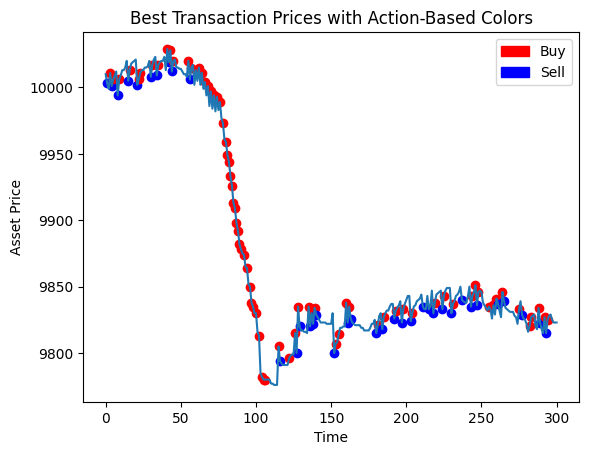

In [ ]:
plot_market_discrete(test_data)

In [ ]:
test_data_passive = test_ray_model(policyPassive(), seed=65, env=env)

{'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x77ff7bdc7b50>, 'mm_agent_params': <abides_markets.configs.agent_params.MarketMakerAgentConfig object at 0x77ff7bdc7cd0>, 'value_agent_params': <abides_markets.configs.agent_params.ValueAgentConfig object at 0x77ff7bdc7820>, 'momentum_agent_params': <abides_markets.configs.agent_params.MomentumAgentConfig object at 0x77ff7bdc7e80>, 'seed': 788209929}
background config is flash_crash
YUPPPPP
(<function build_config at 0x77ff7c07e040>, {'end_time': 34500000000000, 'num_noise_agents': 15, 'num_value_agents': 10, 'num_mm_agents': 19, 'num_long_momentum_agents': 5, 'num_short_momentum_agents': 5, 'oracle_params': <abides_markets.configs.agent_params.GBMOracleConfig object at 0x77ff7bdc7b50>, 'mm_agent_params': <abides_markets.configs.agent_params.Market

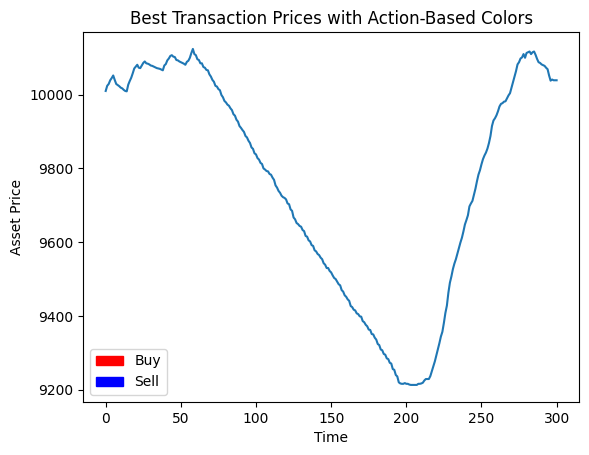

In [ ]:
plot_market_discrete(test_data_passive)

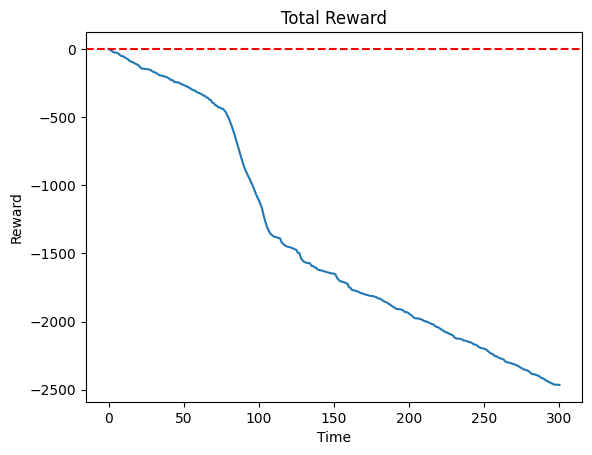

In [ ]:
plot_total_reward(test_data)

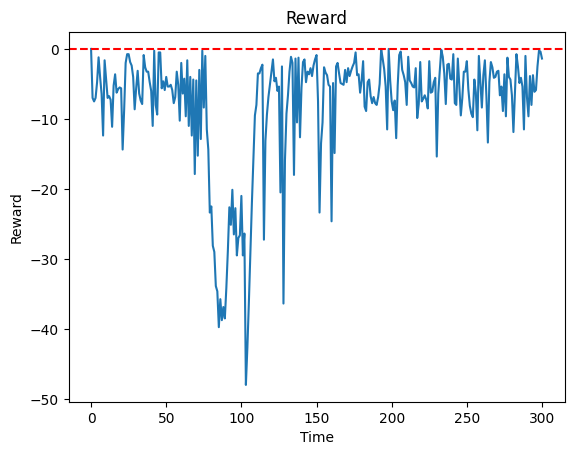

In [ ]:
plot_reward(test_data)

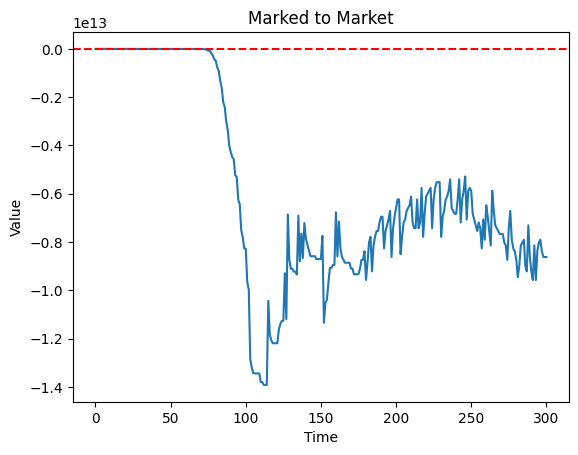

In [ ]:
plot_marked_to_market(test_data)

In [1]:
def calculate_volatility(price_series):
    
    price_series = np.asarray(price_series)
    returns = np.diff(price_series) / price_series[:-1]
    std_dev = np.std(returns)

    return std_dev

def calculate_liquidity(ask_prices, bid_prices):

    ask_prices = np.asarray(ask_prices)
    bid_prices = np.asarray(bid_prices)
    spreads = ask_prices - bid_prices
    average_spread = np.mean(spreads)
    
    return average_spread

def calculate_metrics(data):
    
    data = np.asarray(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    minimum = np.min(data)
    maximum = np.max(data)
    
    return mean, std_dev, minimum, maximum

def market_indicators(test_data):

    indicators = {}
    
    volatility = calculate_volatility(test_data['last_transaction'])
    avg_spread = np.mean(test_data['spread'])
    mean_price, std_price, min_price, max_price = calculate_metrics(test_data['last_transaction'])
    volume = np.mean(test_data['total_volume'])

    indicators['volatility'] = volatility
    indicators['avg_spread'] = avg_spread
    indicators['asset_price'] = {'mean_price': mean_price, 'std_price': std_price, 
                                'min_price': min_price, 'max_price': max_price }
    indicators['volume'] = volume

    return indicators

In [ ]:
import pprint

# Get the default config
default_config = pg.DEFAULT_CONFIG

# Pretty print the default config
pprint.pprint(default_config)

{'_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'type': 'StochasticSampling'},
 'explore': True,
 'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'fake_sampler': False,
 'framework': 'tf',
 'gamma': 0.99,
 'horizon': None,
 'ignore_worker_failures': False,
 'in_

In [ ]:
# Get the default config
default_config = dqn.DEFAULT_CONFIG

# Pretty print the default config
pprint.pprint(default_config)

{'_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'adam_epsilon': 1e-08,
 'batch_mode': 'truncate_episodes',
 'before_learn_on_batch': None,
 'buffer_size': 50000,
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'double_q': True,
 'dueling': True,
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {'explore': False},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'epsilon_timesteps': 10000,
                        'final_epsilon': 0.02,
                        'initial_epsilon'

In [ ]:
# Get the default config
default_config = sac.DEFAULT_CONFIG

# Pretty print the default config
pprint.pprint(default_config)

{'Q_model': {'custom_model': None,
             'custom_model_config': {},
             'fcnet_activation': 'relu',
             'fcnet_hiddens': [256, 256],
             'post_fcnet_activation': None,
             'post_fcnet_hiddens': []},
 '_deterministic_loss': False,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 '_use_beta_distribution': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'batch_mode': 'truncate_episodes',
 'buffer_size': 1000000,
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_

In [9]:
import pprint

# Get the default config
default_config = ppo.DEFAULT_CONFIG

# Pretty print the default config
pprint.pprint(default_config)

{'_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_param': 0.3,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'eager_tracing': False,
 'entropy_coeff': 0.0,
 'entropy_coeff_schedule': None,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'type': 'StochasticSampling'},
 'explore': True,
 'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'fake_sampler': False,
 'framework': 'tf

In [2]:
import os

def remove_first_directory(file_path):
    return os.path.join(*file_path.split(os.sep)[1:])

# Example usage
file_path = "./first_dir/sub_dir/file.txt"
new_path = remove_first_directory(file_path)
print(new_path)  # Output: sub_dir/file.txt


first_dir/sub_dir/file.txt


In [3]:
file_path = "./models/first_dir/sub_dir/file.txt"

In [6]:
'.'+file_path[8:]

'./first_dir/sub_dir/file.txt'